In [101]:
import matplotlib.pyplot as plt
%matplotlib inline
# Predefined ‘magic function’ that display image inline
import matplotlib.image as mimg
# package to help us read in images
import numpy as np
from numpy.random import default_rng
rng=default_rng()  # this is a recommended way to use random number generation now
import os
import random
import math

In [102]:
classes_dict={0:'T-shirt/top',
              1:'Trouser',
              2:'Pullover',
              3:'Dress',
              4:'Coat',
              5:'Sandal',
              6:'Shirt',
              7:'Sneaker',
              8:'Bag',
              9:'Ankle boot'}

In [103]:
def makeDataBase(basename,partition='train',N=None, shuffle=True,normalize=True):
    '''
    This function will create one database that will contain images with their lables
    The data are supposed to be in the paths consisting of
     <basename> / <partition> / <category> / <category>-<index>.jpg
     e.g., FashionMNIST/val/4/4-37.jpg
    Inputs:
        basename (str)  : name of the folder containing all the data. It should be "FashionMNIST"
        partition (str) : "train" or "val" or "test"
        N (int)         : number of examples for each category; when N=None, all samples will be loaded
        shuffle (bool)  : boolean value; if False, samples from category 0 will be returned first and samples from category 9 last
                          if True, samples will be randomly shuffled
        normalize (bool): boolean value; if True, samples are normalized to [-1,1]
    Outputs:
        database (list) : list of tuples (x,y). x is image data. y is numeric label of x 
        
    '''
    database=[]
    for label in range(10): # note: we hardcode number of classes here, it could be another argument
        n = len(os.listdir(os.path.join(basename,partition,str(label)))) if N is None else N
        for i in range(n):          
            imageName=os.path.join(basename,partition,str(label),str(label)+'-'+str(i)+'.jpg')
            imageData=mimg.imread(imageName)
            imageData = np.float32(imageData) if not normalize else np.float32(imageData)/255*2-1
            database.append((imageData,label))
    if shuffle:
        random.shuffle(database)
    return database

In [104]:
def list2ndarray(dataset):
    '''
    This function will take the output from makeDataBase() and return two numpy arrays: X and y
    Inputs:
        dataset (list): list of (sample, label) pairs
    Outputs:
        X (array)     : a 2D numpy array with size (N,D). N is the length of dataset, D is 28*28. 
                        Each row of X is an image sample flattened
        y (array)     : a numpy array with size (N,). y contains numeric labels of corresponding samples
    '''
    num=len(dataset)
    X = np.empty((num,28*28),dtype=np.float32)
    y = np.empty((num,),dtype=int)
    for i in range(num):
        X[i] = dataset[i][0].flatten()
        y[i] = dataset[i][1]
        
    return X, y

In [105]:
def compute_accuracy(yhat,y):
    '''
    This function takes predicted labels and ground truth labels and return accuracy
    Inputs:
        y_hat (array): (N,)-shaped numpy array containing predicted labels OR
                       (N,C) one-hot representation for C classes
        y (array)    : (N,)-shaped numpy array containing ground truth labels OR
                       (N,C) one-hot representation for C classes
    Outputs:
        accu (float) : accuracy between [0.,1.]
    '''
    # if needed, convert from one-hot to class labels
    if len(y.shape) ==2:
        y = np.argmax(y,axis=1)
    if len(yhat.shape) ==2:
        yhat=np.argmax(yhat,axis=1)
    accu = np.count_nonzero(yhat==y)/len(y)
    return accu

You may need to modify the path below to point to wherever you stored the data in Pset 1:

In [121]:
trainset = makeDataBase('../hw1-perceptron/FashionMNIST',partition='train',normalize=True, N=200) # this loads the entire training set, or N=200
trainX, trainy = list2ndarray(trainset)

In [107]:
valset = makeDataBase('../hw1-perceptron/FashionMNIST',partition='val',normalize=True)
testset = makeDataBase('../hw1-perceptron/FashionMNIST',partition='test',normalize=True)
valX, valy = list2ndarray(valset)
testX, testy = list2ndarray(testset)

A couple of functions implementing different schedules for the learning rate

In [108]:
def expSchedule(lr,e,delta):
    '''
    This function computes the updates learning rate (lr) at epoch e, using the decay factor delta;
    it returns the new lr which is the old lr multiplied by delta (e is ignored)
    '''
    return lr*delta

In [109]:
def stepSchedule(lr,t,steps):
    '''
    A scheduled adjustment of the learning rate.
    The current learning rate at the end of epoch e is updated according to the argument 'steps':
    steps specifies the schedule; it's a list, with i-th element being a tuple
    of the form (m,d) which means that once t (number of epoch) reaches m, the lr is multiplie
    by d. So, if initial lr is 0.1, and steps is [(10,.5),(20,.1),(30,.1)] then the lr
    will be 0.1 for epochs 0,..,9; 0.05 for epochs 10,..,19; 0.005 for 20,..,29; and .0005 for 
    epochs 29 and on
    '''
    
    for n in range(len(steps)):
        if t==steps[n][0]:
            return lr*steps[n][1]
    return lr    

In [110]:
def scores(W,X):
    '''
    Compute the scores of the classes on data in X
    Inputs:
        W (array): (d,C) matrix of parameters for the C classes
        X (array): (N,d) data matrix of features; may or may not include the constant feature
    Outputs:
        scores (array): (N,C) matrix of scores for each of the N examples and C classes
    '''
   
    if W.shape[0] == X.shape[1]+1: # need to add the constant feature
        X=np.hstack((X,np.ones((X.shape[0],1))))
    return np.dot(X,W)

In [111]:
def softmax(scores):
    '''
    IMPLEMENT THIS
    Compute the class posterior probabilities from the scores
    Inputs:
        scores (array): output of scores()
    Outputs:
        yhat (array): (N,C) matrix of class posteriors for each of the N examples and C classes
    Note: you may want to include the dynamic range shift trick discussed in class
    '''
    N = len(scores)
    C = len(scores[0])
    res = np.zeros((N,C))
    for i in range(N):
        a = max(scores[i])
        row = list(map(lambda x:math.exp(x - a), scores[i]))
        denominator = sum(row)
        for j in range(C):
            res[i][j] = math.exp(scores[i][j] - a) / denominator
    return res
    

In [112]:
def convert_to_one_hot(y, num_values=10):
    """
    Expects a numpy array of labels like [4, 3, 0, ...]
    Outputs: one-hot encoding, e.g. for the above, assuming 10 classes (possible label values)
        [
            [0,0,0,0,1,0,0,0,0,0],
            [0,0,0,1,0,0,0,0,0,0],
            [1,0,0,0,0,0,0,0,0,0],
            ....
        ]
    """
    one_hot_labels = np.zeros((y.size, num_values))
    one_hot_labels[np.arange(y.size), y] = 1
    return one_hot_labels


In [118]:
def logLikelihood(yhat,y):
    '''
    IMPLEMENT THIS
    Compute the log-likelihood of the model which produced posterior in yhat corresponding to true labels in y
    Inputs:
        yhat (array): (N,C) posterior matrix like that returned by softmax()
        y (array): (N,C) true labels in one-hot format, or
                   (N,) class labels -- your choice (or the function can handle both)
    Outputs:
        ll (float): the average log-likelihood 
    '''
    # C = len(yhat[0])
    # if y.ndim == 1: # if y is a 1-d vector
    #     y = convert_to_one_hot(y, num_values=C)

    N = len(y)
    acc = 0
    for i in range(N):
        acc += math.log(yhat[i][y[i]]) # y[i] is the class we want to select 
        # take log
    return acc / N

In [119]:
def trainSoftmax(X,Y,params):
    '''
    IMPLEMENT THIS
    Inputs:
        X (array): a (N,d) data matrix of features. Does NOT include the constant feature
                   (you need to add it if you want to use it)
        Y (array): a (N,) vector of class labels
        params (dictionary): specification for hyper-parameters. Must include at least the following:
          'num_epochs' : max number of epochs for training;
          'lr' : the (initial) learning rate;
          'scheduler': the function that takes (lr,e,arg) and updates the lr at the end of epoch e;
          'lr_update': the arg to pass to scheduler;
          'batch_size': the size of the mini-batches to use in SGD
          
    Outputs:
        W (array): an (d,C) matrix of parameters
        NLL: the list of values of negative average log-likelihood of the softmax model on the training data, 
             one number for each training epoch covered.
    '''
    d = len(X[0]) # number of features
    C = 10 # number of classes
    W = np.zeros((d, C))
    N = len(X) 
    lr = params['lr']
    scheduler = params['scheduler']
    lr_update = params['lr_update']
    num_epochs = params['num_epochs']
    batch_size = params['batch_size']
    NLL = np.zeros(num_epochs)
    epoch = 0

    while epoch < num_epochs - 1:
        B = random.choices(range(N), k = batch_size) 
        avg_gred = 0
        for i in B: # x is 1 x d
            y = Y[i]
            row_score = np.matmul(X[i], W) # 10 scores of w * x
            m = max(row_score) # max element in x * w
            denominator = sum(list(map(lambda a:math.exp(a - m), row_score)))

            single_score = np.dot(X[i], W[:,y]) # top one score of w_c * x
            numerator = X[i] * math.exp(single_score - m)
            
            gred = - X[i] + numerator / denominator
            W[:, y] -= lr * gred / batch_size
        
        yhat = softmax(scores(W, X))
        NLL[epoch] = - logLikelihood(yhat, Y)
        
        lr = scheduler(lr, epoch, lr_update)
        epoch += 1
        
    return W,NLL

In [120]:
# example of setting the params list to pass to the training code; add your own elements that
# specify stopping criteria and anything else
params={'lr':.1, 'num_epochs':40,'scheduler': stepSchedule,'batch_size':200,'lr_update':[(20,.5),(30,.1)]} # ecpho 40, 200

Once you complete the code, follow the problem set assignment, run the experiments, and report your findings.

In [125]:
def predict_acc(W, NLL):
    predict = softmax(scores(W, testX))
    N = len(testX)
    y_predict = np.zeros(N)
    for i in range(N):
        y_predict[i] = np.argmax(predict[i])
    acc = compute_accuracy(y_predict, testy)
    return acc


In [126]:
# Step scheduler

best_acc = 0
best_param = {}

for lr in 0.1, 0.5, 1:
    for num_epochs in 20, 40, 100:
        for batch_size in 50, 100:
            for lr_update in [(20,.5),(30,.1)], [(10,.5),(20,.1),(30,.2)]:
                params={'lr':lr, 'num_epochs':num_epochs,'scheduler': stepSchedule,'batch_size':batch_size,'lr_update':lr_update}
                W, NLL = trainSoftmax(trainX, trainy, params)
                acc = predict_acc(W, NLL)
                
                if acc > best_acc:
                    best_acc = acc
                    best_param = params

                print("acc", acc, "params lr, num_epochs, batch_size, lr_update", lr, num_epochs, batch_size, lr_update)

print("Step Scheduler best acc", best_acc)

acc 0.6493 params lr, num_epochs, batch_size, lr_update 0.1 20 50 [(20, 0.5), (30, 0.1)]
acc 0.6192 params lr, num_epochs, batch_size, lr_update 0.1 20 50 [(10, 0.5), (20, 0.1), (30, 0.2)]
acc 0.6217 params lr, num_epochs, batch_size, lr_update 0.1 20 100 [(20, 0.5), (30, 0.1)]
acc 0.673 params lr, num_epochs, batch_size, lr_update 0.1 20 100 [(10, 0.5), (20, 0.1), (30, 0.2)]
acc 0.6484 params lr, num_epochs, batch_size, lr_update 0.1 40 50 [(20, 0.5), (30, 0.1)]
acc 0.655 params lr, num_epochs, batch_size, lr_update 0.1 40 50 [(10, 0.5), (20, 0.1), (30, 0.2)]
acc 0.6642 params lr, num_epochs, batch_size, lr_update 0.1 40 100 [(20, 0.5), (30, 0.1)]
acc 0.6646 params lr, num_epochs, batch_size, lr_update 0.1 40 100 [(10, 0.5), (20, 0.1), (30, 0.2)]
acc 0.6599 params lr, num_epochs, batch_size, lr_update 0.1 100 50 [(20, 0.5), (30, 0.1)]
acc 0.6504 params lr, num_epochs, batch_size, lr_update 0.1 100 50 [(10, 0.5), (20, 0.1), (30, 0.2)]
acc 0.6704 params lr, num_epochs, batch_size, lr_up

In [128]:
# Exp schedular 

best_acc = 0
best_param = {}

for lr in 0.1, 0.5, 1:
    for num_epochs in 20, 40, 100:
        for batch_size in 50, 100:
            for lr_update in 0.3, 0.5, 0.9:
                params={'lr':lr, 'num_epochs':num_epochs,'scheduler': expSchedule,'batch_size':batch_size,'lr_update':lr_update}
                W, NLL = trainSoftmax(trainX, trainy, params)
                acc = predict_acc(W, NLL)
                
                if acc > best_acc:
                    best_acc = acc
                    best_param = params

                print("acc", acc, "params lr, num_epochs, batch_size, lr_update", lr, num_epochs, batch_size, lr_update)

print("Expential Scheduler best acc", best_acc)

acc 0.4276 params lr, num_epochs, batch_size, lr_update 0.1 20 50 0.3
acc 0.5852 params lr, num_epochs, batch_size, lr_update 0.1 20 50 0.5
acc 0.6626 params lr, num_epochs, batch_size, lr_update 0.1 20 50 0.9
acc 0.4063 params lr, num_epochs, batch_size, lr_update 0.1 20 100 0.3
acc 0.5083 params lr, num_epochs, batch_size, lr_update 0.1 20 100 0.5
acc 0.6559 params lr, num_epochs, batch_size, lr_update 0.1 20 100 0.9
acc 0.3462 params lr, num_epochs, batch_size, lr_update 0.1 40 50 0.3
acc 0.443 params lr, num_epochs, batch_size, lr_update 0.1 40 50 0.5
acc 0.6737 params lr, num_epochs, batch_size, lr_update 0.1 40 50 0.9
acc 0.4557 params lr, num_epochs, batch_size, lr_update 0.1 40 100 0.3
acc 0.5171 params lr, num_epochs, batch_size, lr_update 0.1 40 100 0.5
acc 0.6496 params lr, num_epochs, batch_size, lr_update 0.1 40 100 0.9
acc 0.382 params lr, num_epochs, batch_size, lr_update 0.1 100 50 0.3
acc 0.541 params lr, num_epochs, batch_size, lr_update 0.1 100 50 0.5
acc 0.658 param

In [130]:
# best paramer to test 

params={'lr': 1, 'num_epochs': 100,'scheduler': stepSchedule,'batch_size':100,'lr_update':[(20, 0.5), (30, 0.1)]}
W, NLL = trainSoftmax(trainX, trainy, params)
acc = predict_acc(W, NLL)

print("test acc", acc)

test acc 0.677


# Visualize W

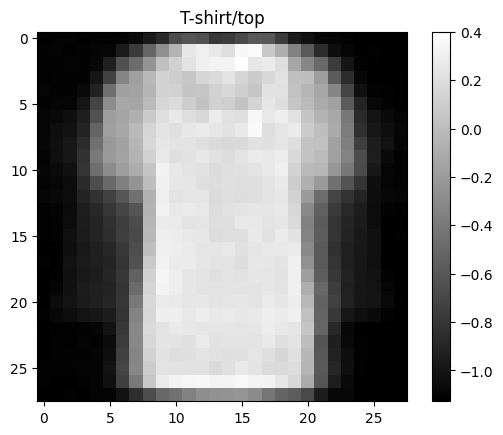

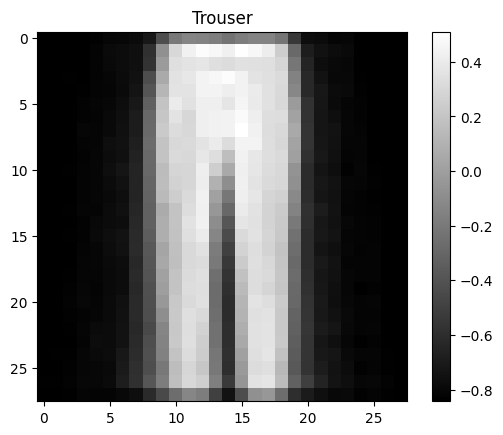

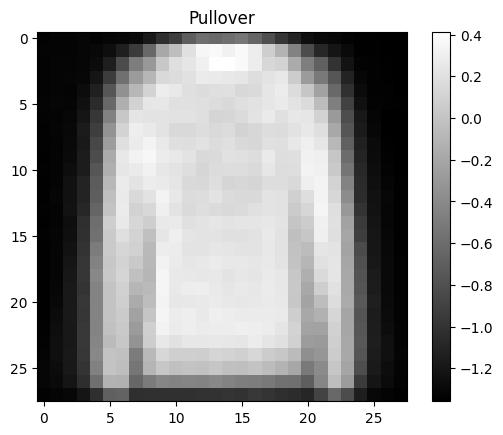

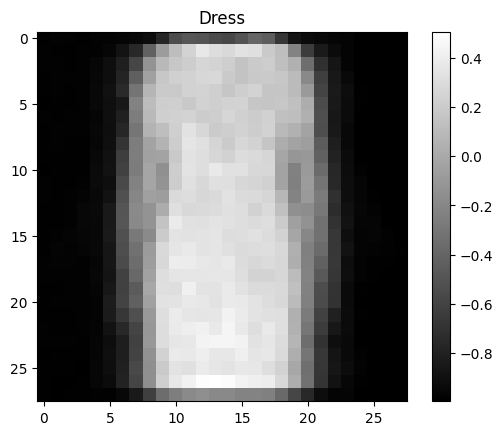

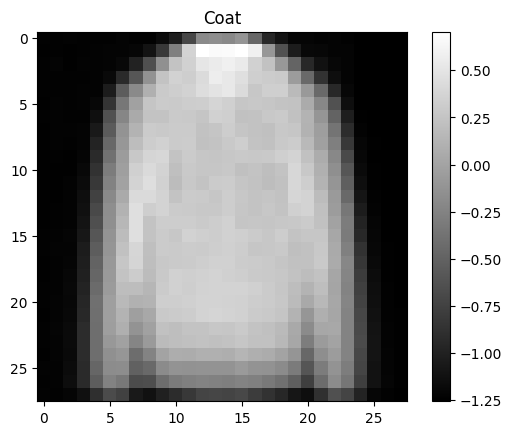

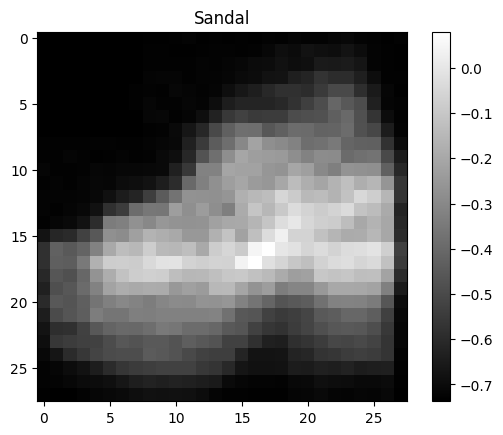

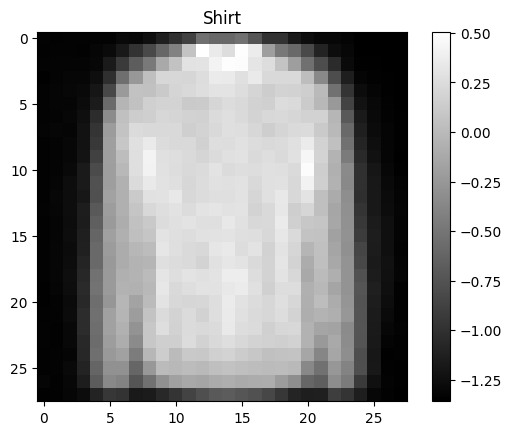

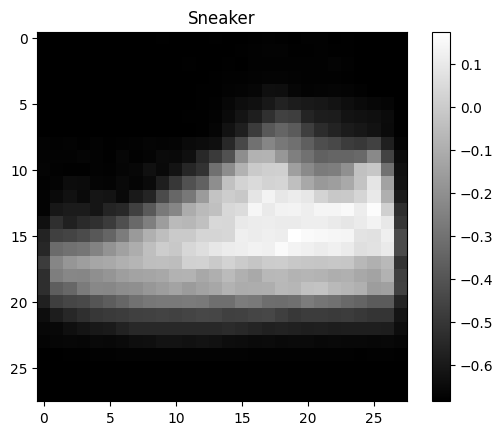

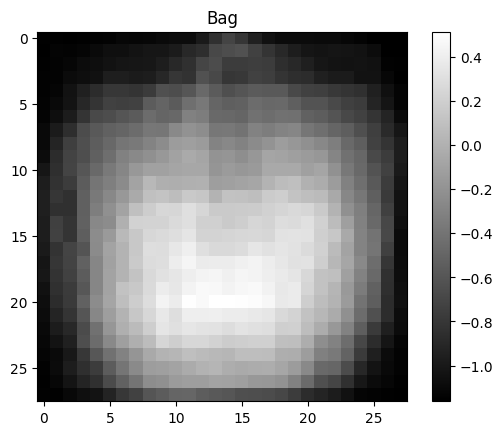

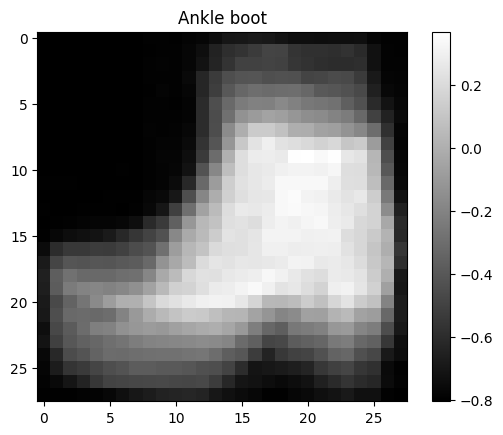

In [131]:
for c in range(10):
    plt.imshow(W[-28**2:, c].reshape(28, 28),cmap="gray")
    plt.colorbar()
    plt.title(classes_dict[c])
    plt.show()

## Observations
- The brighter the color, the higher the weight for that pixel, indicating that such feature has a high predictive power. It contributes more to the score thus the label of a picture. 
- The dark pixels indicate that these features have negative weights, meaning that they do not tell much about what the label of the input will be.
- As the shape of the bright pixels constitue the "main item" of a picture, it means our model correctly "learns" which pixels are important in that they can predict the label.